https://jovian.ai/aakashns/python-sklearn-logistic-regression

# **Todos**

* Explore Kaggle's Codes for This Dataset

# **Informations**
* %%capture to hide output

## The following topics are covered

- Downloading a real-world dataset from Kaggle
- Exploratory data analysis and visualization
- Splitting a dataset into training, validation & test sets
- Filling/imputing missing values in numeric columns
- Scaling numeric features to a $(0,1)$ range
- Encoding categorical columns as one-hot vectors
- Training a logistic regression model using Scikit-learn
- Evaluating a model using a validation set and test set
- Saving a model to disk and loading it back


## Logistic Regression for Solving Classification Problems

Logistic regression is a commonly used technique for solving binary classification problems. In a logistic regression model:

- we take linear combination (or weighted sum of the input features)
- we apply the sigmoid function to the result to obtain a number between 0 and 1
- this number represents the probability of the input being classified as "Yes"
- instead of RMSE, the cross entropy loss function is used to evaluate the results


Here's a visual summary of how a logistic regression model is structured ([source](http://datahacker.rs/005-pytorch-logistic-regression-in-pytorch/)):


<img src="https://i.imgur.com/YMaMo5D.png" width="480">

The sigmoid function applied to the linear combination of inputs has the following formula:

<img src="https://i.imgur.com/sAVwvZP.png" width="400">


The output of the sigmoid function is called a logistic, hence the name _logistic regression_. For a mathematical discussion of logistic regression, sigmoid activation and cross entropy, check out [this YouTube playlist](https://www.youtube.com/watch?v=-la3q9d7AKQ&list=PLNeKWBMsAzboR8vvhnlanxCNr2V7ITuxy&index=1). Logistic regression can also be applied to multi-class classification problems, with a few modifications.


### Classification

Here are some examples of classification problems:

- [Rainfall prediction](https://kaggle.com/jsphyg/weather-dataset-rattle-package): Predicting whether it will rain tomorrow using today's weather data (classes are "Will Rain" and "Will Not Rain")
- [Breast cancer detection](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data): Predicting whether a tumor  is "benign" (noncancerous) or "malignant" (cancerous) using information like its radius, texture etc.
- [Loan Repayment Prediction](https://www.kaggle.com/c/home-credit-default-risk) - Predicting whether applicants will repay a home loan based on factors like age, income, loan amount, no. of children etc.
- [Handwritten Digit Recognition](https://www.kaggle.com/c/digit-recognizer) - Identifying which digit from 0 to 9 a picture of handwritten text represents.

Classification problems can be binary (yes/no) or multiclass (picking one of many classes).

## Problem Statement

> **QUESTION**: The [Rain in Australia dataset](https://kaggle.com/jsphyg/weather-dataset-rattle-package) contains about 10 years of daily weather observations from numerous Australian weather stations.

As a data scientist, you are tasked with creating a fully-automated system that can use today's weather data for a given location to predict whether it will rain at the location tomorrow.

# **Imports**

In [1]:
import kagglehub

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from imblearn.over_sampling import RandomOverSampler, SMOTE

from sklearn.linear_model import LogisticRegression
import xgboost as xgb

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

pd.set_option('future.no_silent_downcasting', True)
plt.style.use("Solarize_Light2")

# **ENV**

In [2]:
sample = True # if True: use a sample of dataset for testing and analyzing
fraction = 1

split_by_year = True

scaler_model = MinMaxScaler
# scaler_model = StandardScaler

imputer = SimpleImputer(strategy="mean")
# imputer = IterativeImputer()

impute_cat = False
cat_imputer = SimpleImputer(strategy='most_frequent')

over_sampling = False
oversample_model = RandomOverSampler
# oversample_model = SMOTE

# **Load Dataset**

In [3]:
# Download latest version
path = kagglehub.dataset_download("jsphyg/weather-dataset-rattle-package")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/weather-dataset-rattle-package


In [4]:
weather_data = pd.read_csv("/kaggle/input/weather-dataset-rattle-package/weatherAUS.csv")
weather_data.head(5)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


## Sample
When working with massive datasets containing millions of rows, it's a good idea to work with a sample initially, to quickly set up your model training notebook.

In [5]:
if sample:
    weather_data = weather_data.sample(frac=fraction).copy()

# **Convert Binary Categoricals to Numerical**

### Get Categorical Columns

In [6]:
categorical_cols = weather_data.select_dtypes(include=["object"]).columns.tolist()

In [7]:
weather_data[categorical_cols].nunique()

,0
Date,3436
Location,49
WindGustDir,16
WindDir9am,16
WindDir3pm,16
RainToday,2
RainTomorrow,2


RainToday and RainTomorrow

### Check NaN in Binary Categoricals

In [8]:
weather_data[["RainToday", "RainTomorrow"]].isna().sum()

,0
RainToday,3261
RainTomorrow,3267


In [9]:
weather_data = weather_data.dropna(subset=["RainToday", "RainTomorrow"])
weather_data[["RainToday", "RainTomorrow"]].isna().sum()

,0
RainToday,0
RainTomorrow,0


### Converting

In [10]:
weather_df = weather_data.copy()
weather_df[["RainToday", "RainTomorrow"]] = weather_df[["RainToday", "RainTomorrow"]].replace({"Yes": 1, "No": 0}).astype(np.int8)
weather_df = weather_df.rename(columns={"RainToday": "isRainToday", "RainTomorrow": "isRainTomorrow"})
weather_df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,isRainToday,isRainTomorrow
45355,2016-11-06,Wollongong,14.2,22.7,0.0,NaN,NaN,W,52.0,WSW,...,28.0,43.0,1008.5,1007.8,NaN,NaN,18.7,20.4,0,0
36334,2016-12-13,SydneyAirport,21.1,39.2,0.0,10.2,11.4,NNE,56.0,NW,...,44.0,27.0,1015.3,1010.4,3.0,5.0,28.8,34.1,0,0
81333,2009-12-02,Dartmoor,8.9,30.7,0.0,7.0,12.5,SSW,33.0,ENE,...,60.0,19.0,1018.7,1016.1,NaN,NaN,18.2,28.7,0,0
85721,2013-06-08,Brisbane,13.4,23.0,0.0,1.8,2.6,SSE,26.0,SW,...,85.0,83.0,1026.1,1024.1,7.0,8.0,15.8,19.6,0,1
33798,2009-10-06,SydneyAirport,11.5,19.4,6.4,2.6,6.4,SSW,52.0,W,...,87.0,50.0,1020.5,1016.5,7.0,3.0,12.8,18.9,1,1


# **Analyze Dataset**

### Correlation

In [11]:
numerical_df = weather_df.select_dtypes(include=np.number).copy()
cm = numerical_df.corr()

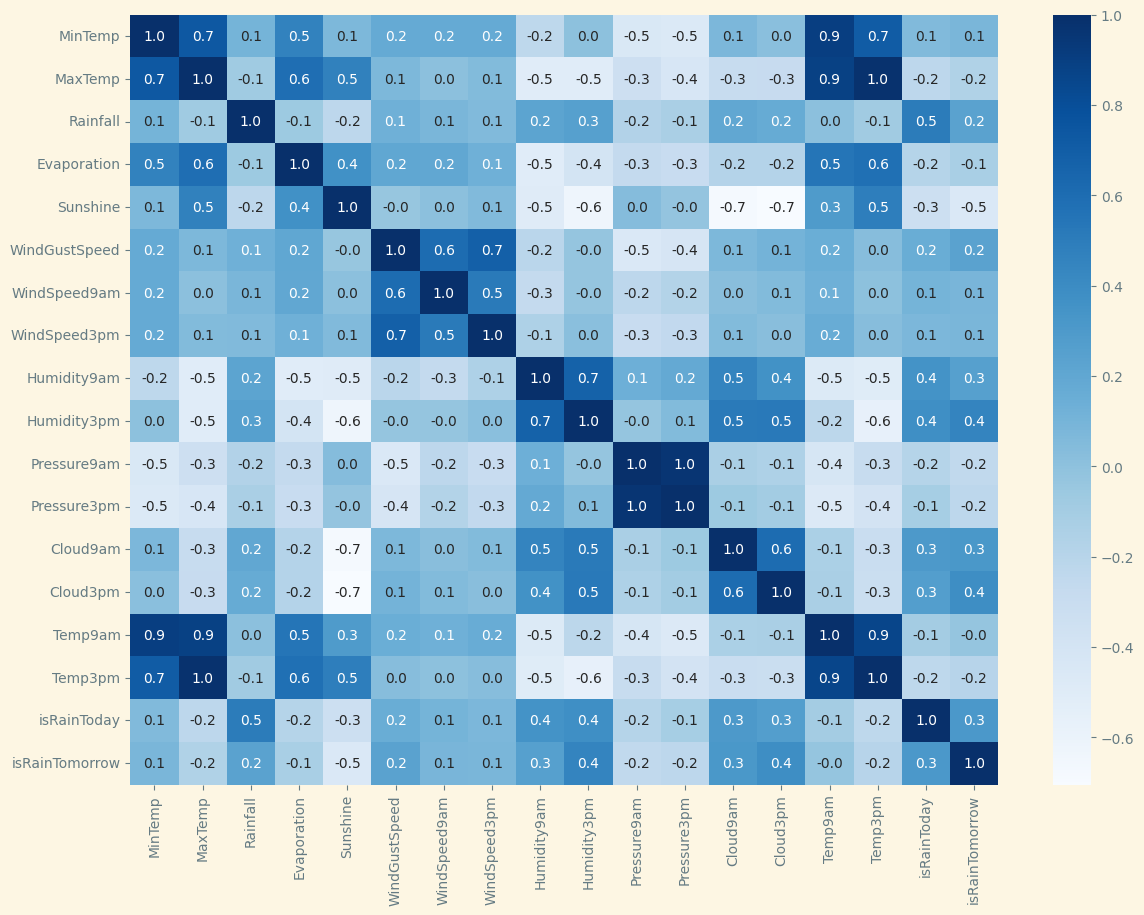

In [12]:
fig, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(data=cm, annot=True, cmap="Blues", ax=ax, fmt=".1f")
plt.show()

### Histogram

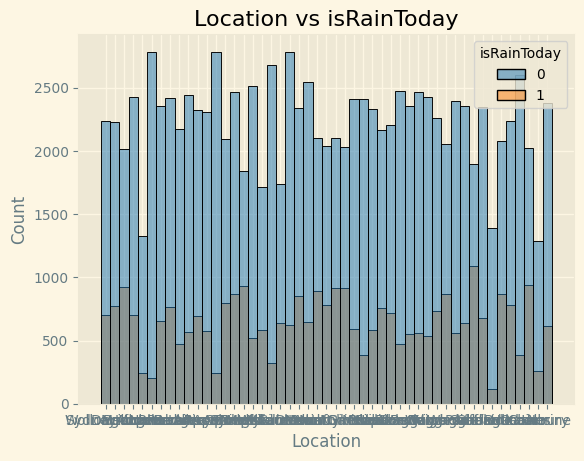

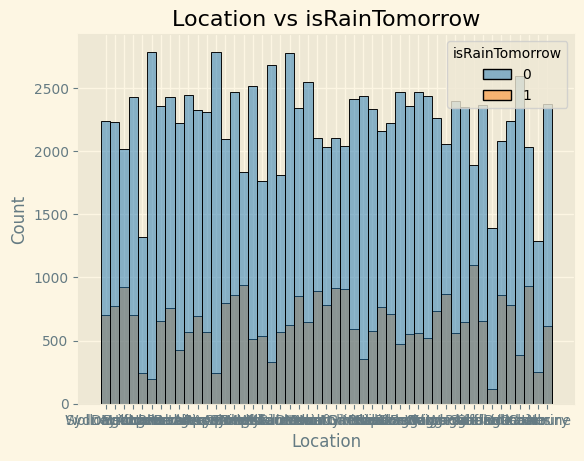

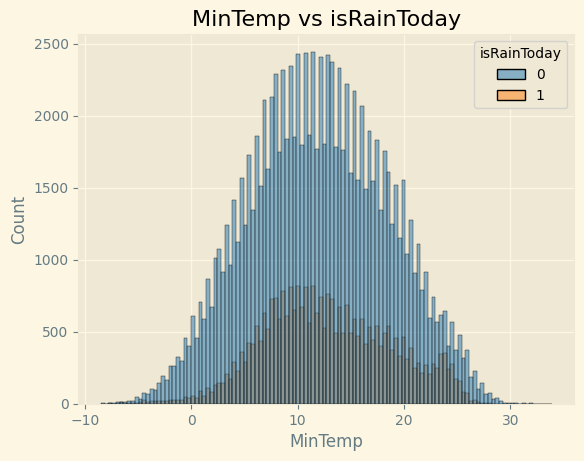

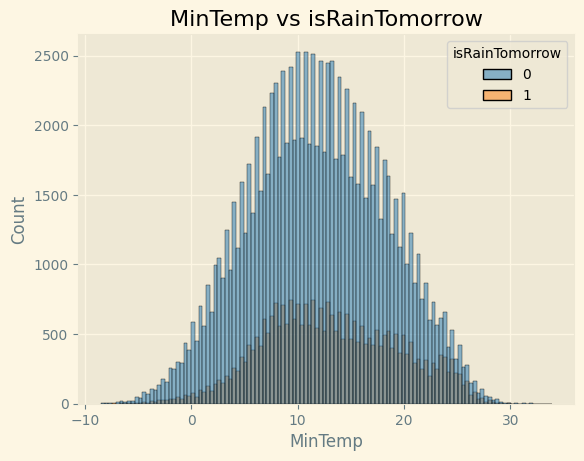

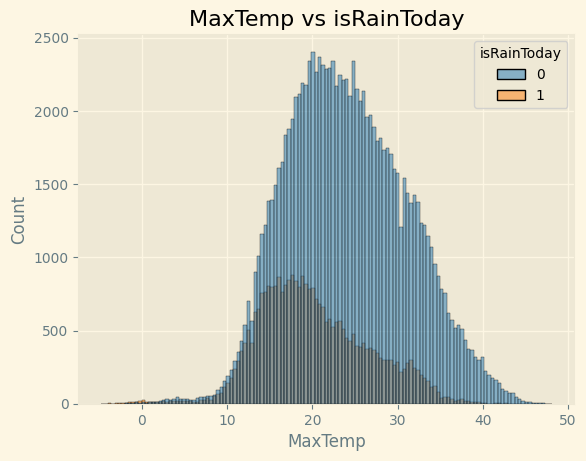

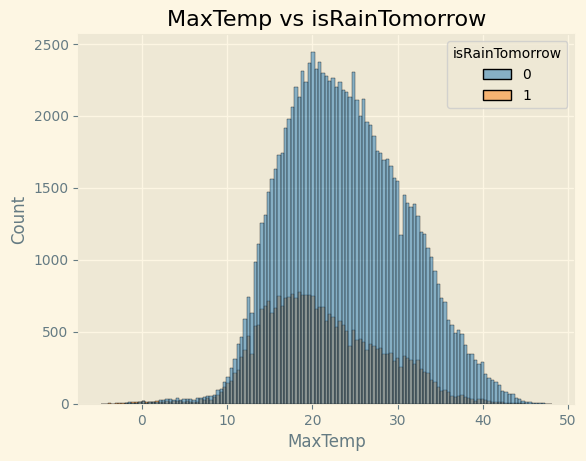

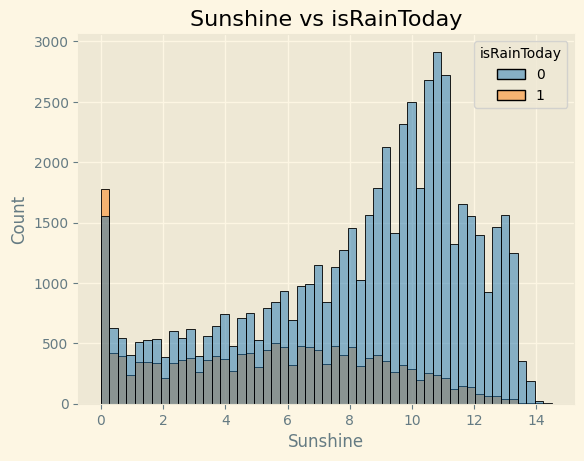

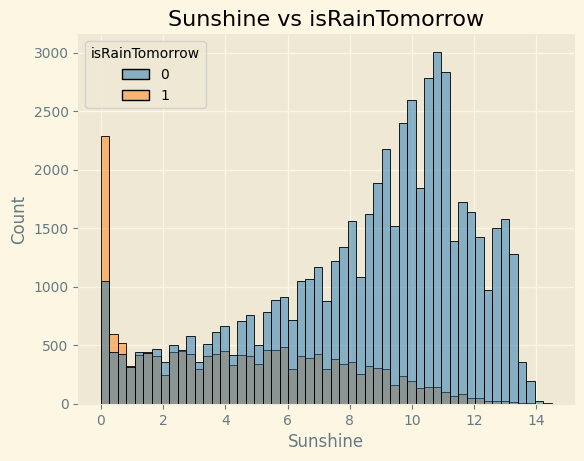

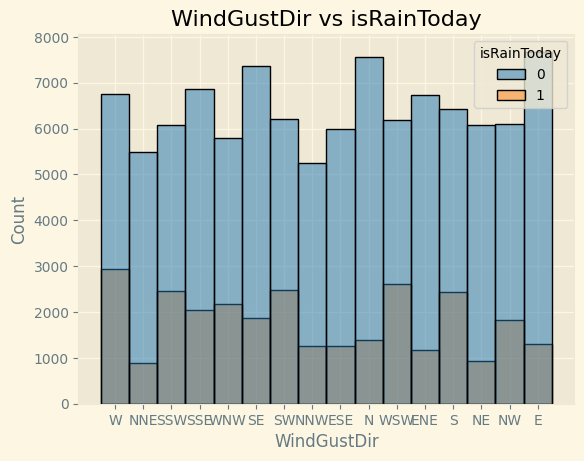

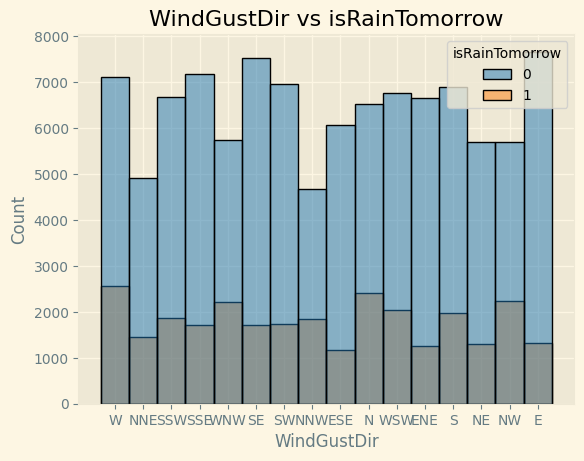

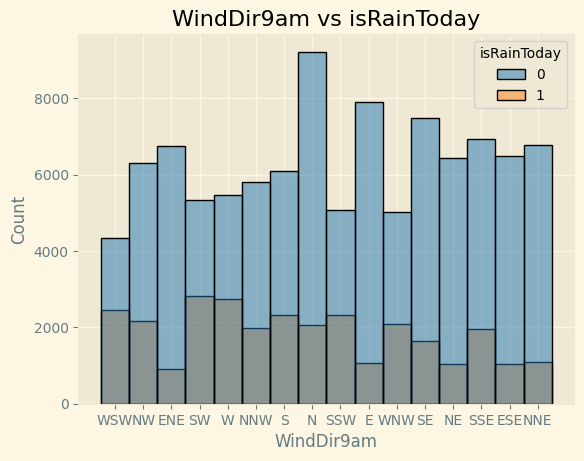

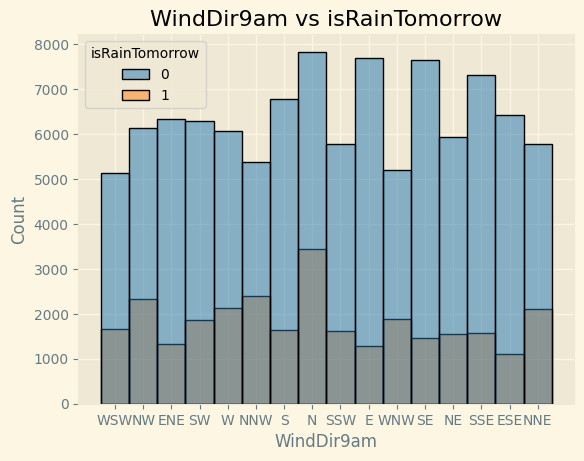

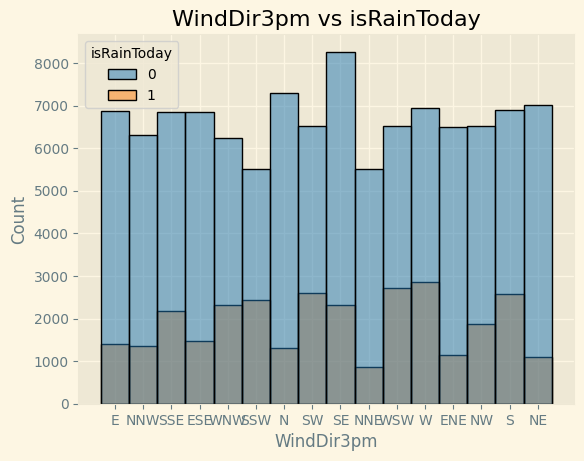

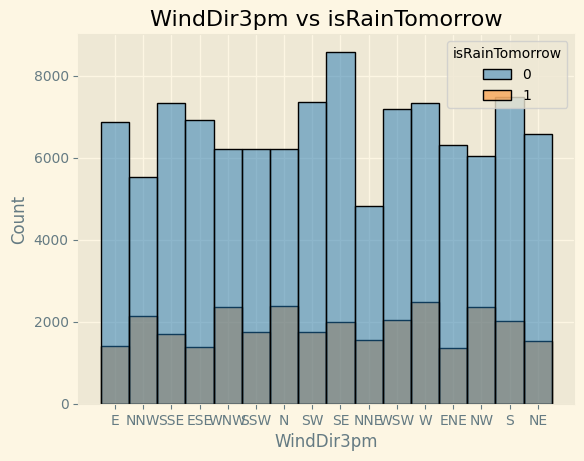

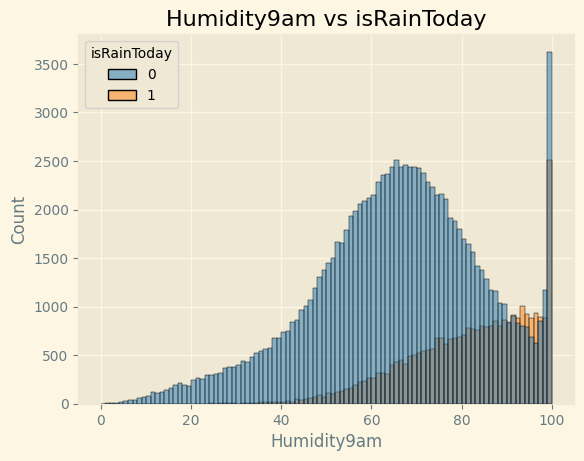

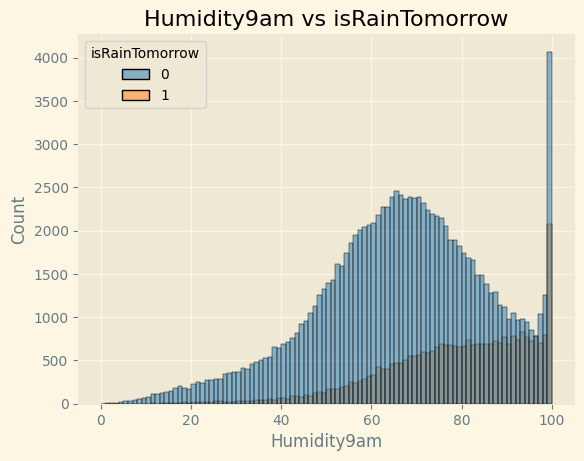

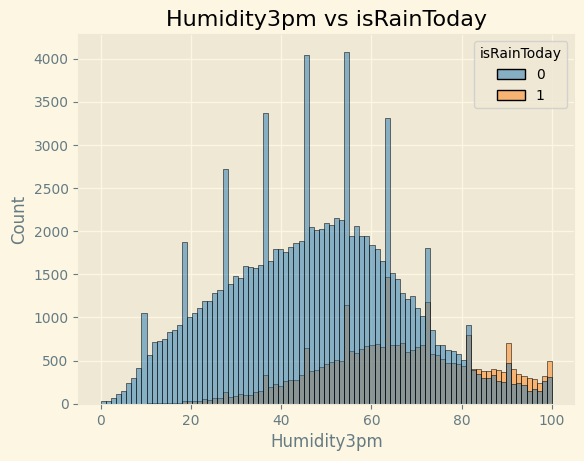

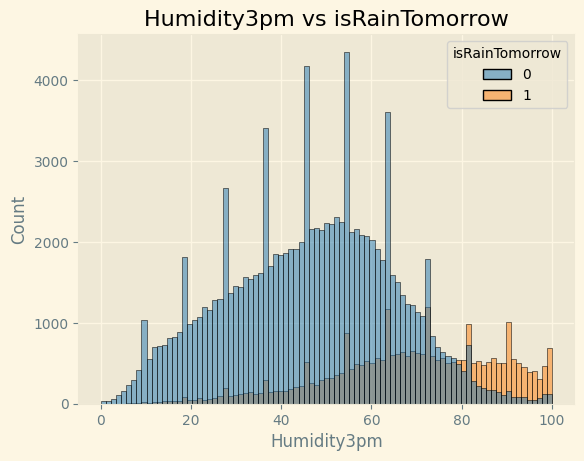

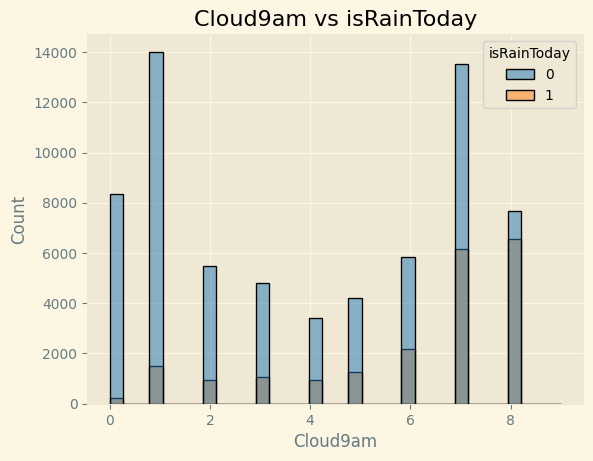

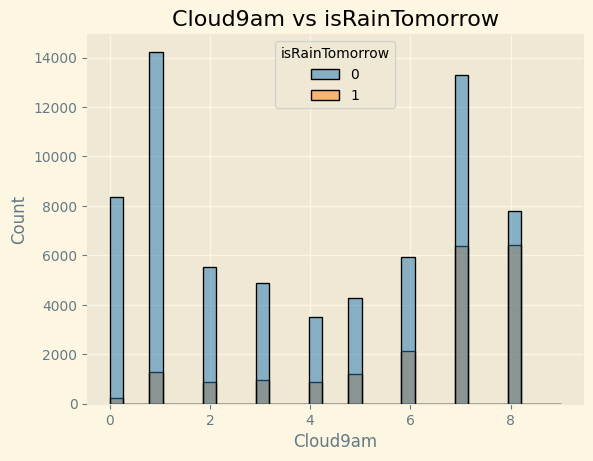

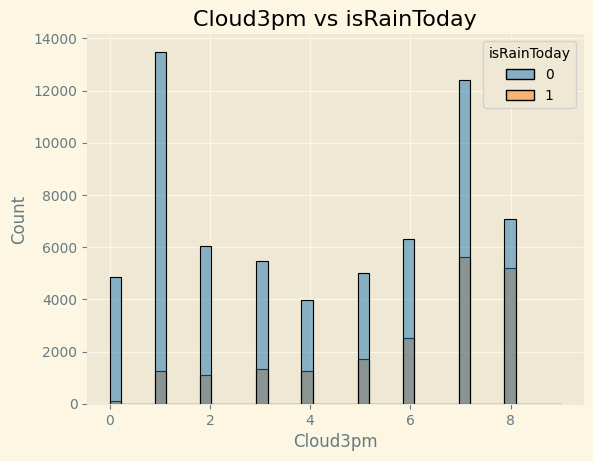

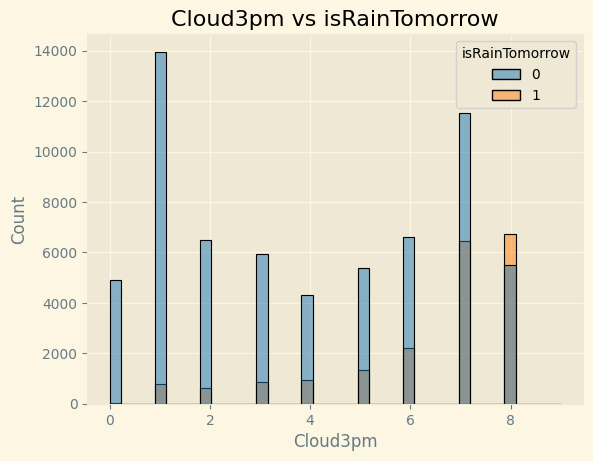

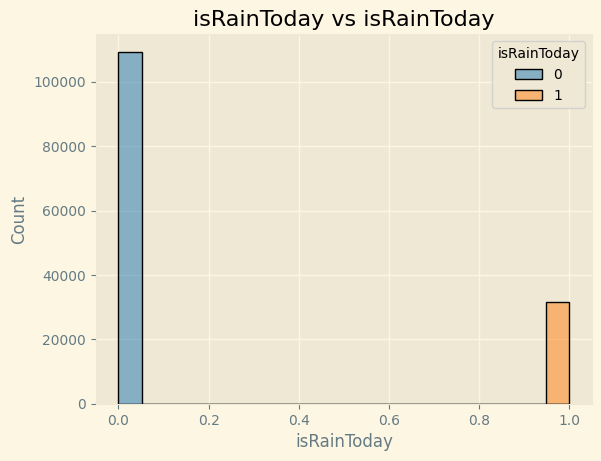

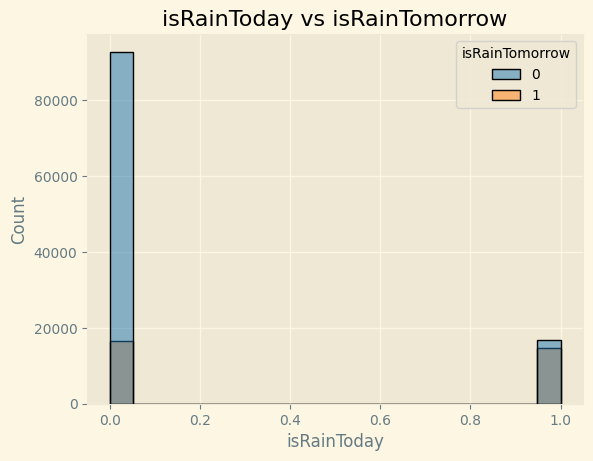

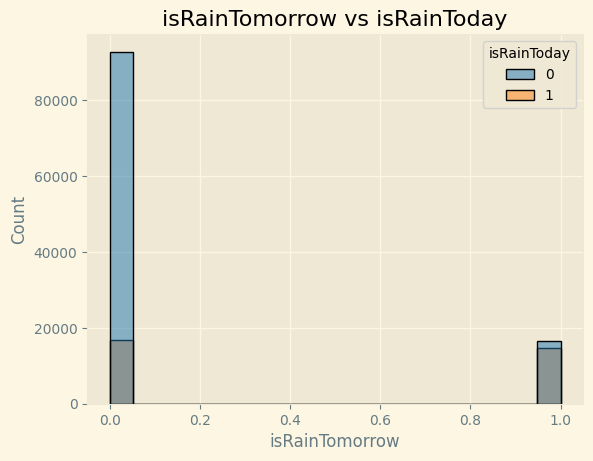

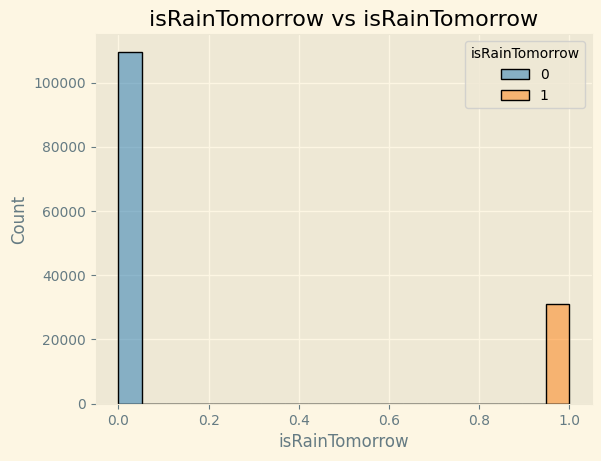

In [13]:
if sample:
    for column in weather_df.columns[[1, 2, 3, 6, 7, 9, 10, 13, 14, 17, 18, 21, 22]]:
        sns.histplot(data=weather_df, x=column, hue="isRainToday", palette="tab10")
        plt.title(f"{column} vs isRainToday")
        plt.show()
        sns.histplot(data=weather_df, x=column, hue="isRainTomorrow", palette="tab10")
        plt.title(f"{column} vs isRainTomorrow")
        plt.show()

### Scatter

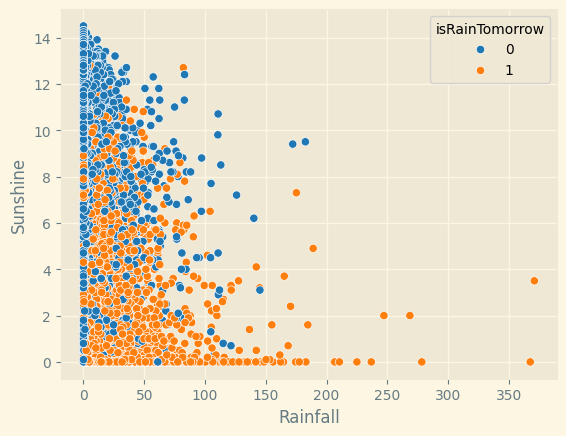

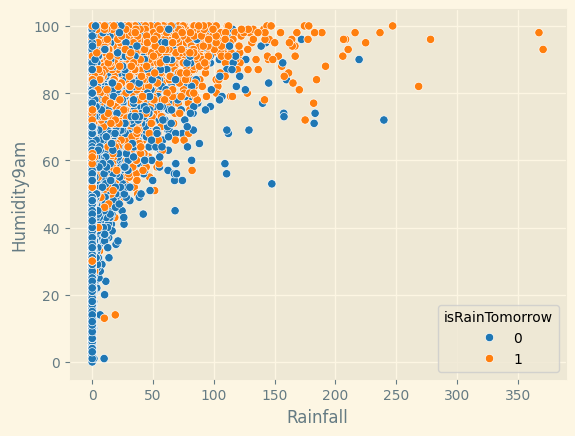

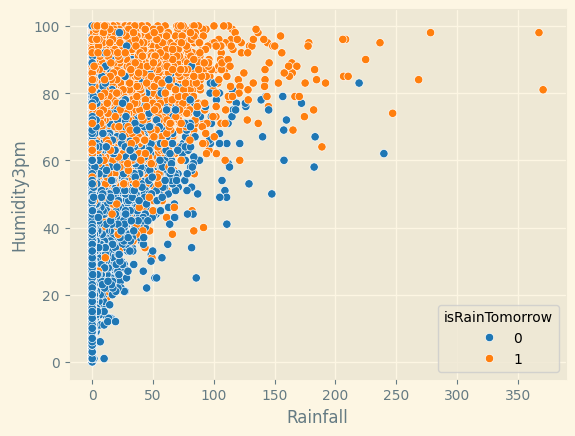

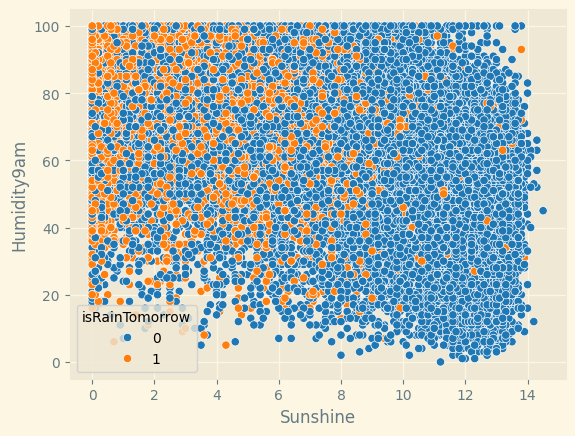

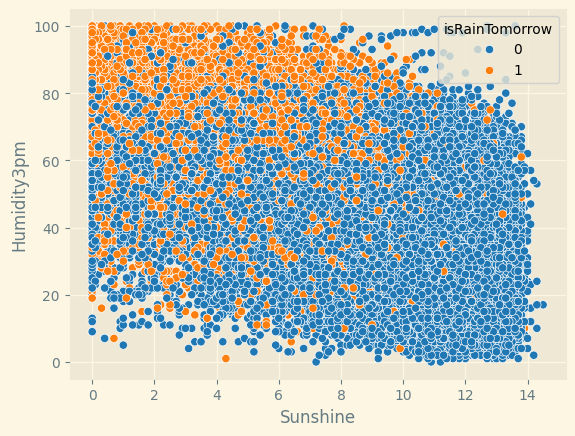

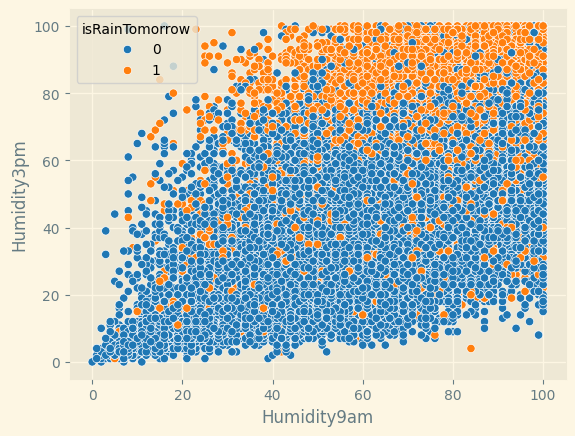

In [14]:
if sample:
    columns = ["Rainfall", "Sunshine", "Humidity9am", "Humidity3pm"]

    for i in range(len(columns)):
        for j in range(i + 1, len(columns)):
            sns.scatterplot(data=weather_df, x=columns[i], y=columns[j], hue="isRainTomorrow", palette="tab10")
            plt.show()

# **Preprocessing**

## 0.Identifying Input and Target Columns

Often, not all the columns in a dataset are useful for training a model. In the current dataset, we can ignore the `Date` column, since we only want to weather conditions to make a prediction about whether it will rain the next day.

Let's create a list of input columns, and also identify the target column.

In [15]:
input_cols = weather_df.columns[1:-1] # drop Date and isRainTomorrow
target_col = "isRainTomorrow"

In [16]:
print(input_cols)

Index(['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'isRainToday'],
      dtype='object')


## 1.Identify which of the columns are numerical and which ones are categorical

In [17]:
numeric_cols  = weather_df.select_dtypes(include=np.number).columns[:-2].tolist()
categorical_cols = weather_df.select_dtypes(include=["object"]).columns.tolist()

In [18]:
print(numeric_cols)
print(categorical_cols)

['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']
['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']


In [19]:
weather_df[categorical_cols].nunique()

,0
Date,3436
Location,49
WindGustDir,16
WindDir9am,16
WindDir3pm,16


Date is not categorical

In [20]:
categorical_cols = categorical_cols[1:]

## 2.Handle Nans

Imputing Missing Numeric Data

Machine learning models can't work with missing numerical data. The process of filling missing values is called imputation.

<img src="https://i.imgur.com/W7cfyOp.png" width="480">

There are several techniques for imputation, but we'll use the most basic one: replacing missing values with the average value in the column using the `SimpleImputer` class from `sklearn.impute`.

### Numericals

In [21]:
weather_df[numeric_cols].isna().sum()

,0
MinTemp,468
MaxTemp,307
Rainfall,0
Evaporation,59694
Sunshine,66805
WindGustSpeed,9105
WindSpeed9am,1055
WindSpeed3pm,2531
Humidity9am,1517
Humidity3pm,3501


| Column Type        | Recommended Imputer                       |
| ------------------ | ----------------------------------------- |
| Numerical          | `SimpleImputer(strategy='median')`        |
| Categorical        | `SimpleImputer(strategy='most_frequent')` |
| Advanced (numeric) | `KNNImputer` or `IterativeImputer`        |


In [22]:
imputer.fit(weather_df[numeric_cols])

SimpleImputer()

In [23]:
weather_df[numeric_cols] = imputer.transform(weather_df[numeric_cols])

In [24]:
weather_df[numeric_cols].isna().sum()

,0
MinTemp,0
MaxTemp,0
Rainfall,0
Evaporation,0
Sunshine,0
WindGustSpeed,0
WindSpeed9am,0
WindSpeed3pm,0
Humidity9am,0
Humidity3pm,0


### Categorical

In [25]:
weather_df[categorical_cols].isna().sum()

,0
Location,0
WindGustDir,9163
WindDir9am,9660
WindDir3pm,3670


In [26]:
if impute_cat:
    weather_df[categorical_cols] = cat_imputer.fit_transform(weather_df[categorical_cols])
    print(weather_df[numeric_cols].isna().sum().sum())

## 3.Encoding Categorical Data

Since machine learning models can only be trained with numeric data, we need to convert categorical data to numbers. A common technique is to use one-hot encoding for categorical columns.

<img src="https://i.imgur.com/n8GuiOO.png" width="640">

One hot encoding involves adding a new binary (0/1) column for each unique category of a categorical column.

In [27]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

In [28]:
encoder.fit(weather_df[categorical_cols])

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [29]:
encoder.categories_

[array(['Adelaide', 'Albany', 'Albury', 'AliceSprings', 'BadgerysCreek',
        'Ballarat', 'Bendigo', 'Brisbane', 'Cairns', 'Canberra', 'Cobar',
        'CoffsHarbour', 'Dartmoor', 'Darwin', 'GoldCoast', 'Hobart',
        'Katherine', 'Launceston', 'Melbourne', 'MelbourneAirport',
        'Mildura', 'Moree', 'MountGambier', 'MountGinini', 'Newcastle',
        'Nhil', 'NorahHead', 'NorfolkIsland', 'Nuriootpa', 'PearceRAAF',
        'Penrith', 'Perth', 'PerthAirport', 'Portland', 'Richmond', 'Sale',
        'SalmonGums', 'Sydney', 'SydneyAirport', 'Townsville',
        'Tuggeranong', 'Uluru', 'WaggaWagga', 'Walpole', 'Watsonia',
        'Williamtown', 'Witchcliffe', 'Wollongong', 'Woomera'],
       dtype=object),
 array(['E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE',
        'SSW', 'SW', 'W', 'WNW', 'WSW', nan], dtype=object),
 array(['E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE',
        'SSW', 'SW', 'W', 'WNW', 'WSW', nan], dtype=object),
 ar

The encoder has created a list of categories for each of the categorical columns in the dataset.

We can generate column names for each individual category using `get_feature_names`.

In [30]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
print(encoded_cols)

['Location_Adelaide', 'Location_Albany', 'Location_Albury', 'Location_AliceSprings', 'Location_BadgerysCreek', 'Location_Ballarat', 'Location_Bendigo', 'Location_Brisbane', 'Location_Cairns', 'Location_Canberra', 'Location_Cobar', 'Location_CoffsHarbour', 'Location_Dartmoor', 'Location_Darwin', 'Location_GoldCoast', 'Location_Hobart', 'Location_Katherine', 'Location_Launceston', 'Location_Melbourne', 'Location_MelbourneAirport', 'Location_Mildura', 'Location_Moree', 'Location_MountGambier', 'Location_MountGinini', 'Location_Newcastle', 'Location_Nhil', 'Location_NorahHead', 'Location_NorfolkIsland', 'Location_Nuriootpa', 'Location_PearceRAAF', 'Location_Penrith', 'Location_Perth', 'Location_PerthAirport', 'Location_Portland', 'Location_Richmond', 'Location_Sale', 'Location_SalmonGums', 'Location_Sydney', 'Location_SydneyAirport', 'Location_Townsville', 'Location_Tuggeranong', 'Location_Uluru', 'Location_WaggaWagga', 'Location_Walpole', 'Location_Watsonia', 'Location_Williamtown', 'Loca

In [31]:
weather_df_hot_encoded = weather_df.copy()
weather_df_hot_encoded[encoded_cols] = encoder.transform(weather_df_hot_encoded[categorical_cols])

<ipython-input-31-030f328ac6a5>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  weather_df_hot_encoded[encoded_cols] = encoder.transform(weather_df_hot_encoded[categorical_cols])
<ipython-input-31-030f328ac6a5>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  weather_df_hot_encoded[encoded_cols] = encoder.transform(weather_df_hot_encoded[categorical_cols])
<ipython-input-31-030f328ac6a5>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfor

In [32]:
print(weather_df_hot_encoded.columns)

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am',
       ...
       'WindDir3pm_NW', 'WindDir3pm_S', 'WindDir3pm_SE', 'WindDir3pm_SSE',
       'WindDir3pm_SSW', 'WindDir3pm_SW', 'WindDir3pm_W', 'WindDir3pm_WNW',
       'WindDir3pm_WSW', 'WindDir3pm_nan'],
      dtype='object', length=123)


## 4.Training, Validation and Test Sets

### Description


While building real-world machine learning models, it is quite common to split the dataset into three parts:

1. **Training set** - used to train the model, i.e., compute the loss and adjust the model's weights using an optimization technique.


2. **Validation set** - used to evaluate the model during training, tune model hyperparameters (optimization technique, regularization etc.), and pick the best version of the model. Picking a good validation set is essential for training models that generalize well. [Learn more here.](https://www.fast.ai/2017/11/13/validation-sets/)


3. **Test set** - used to compare different models or approaches and report the model's final accuracy. For many datasets, test sets are provided separately. The test set should reflect the kind of data the model will encounter in the real-world, as closely as feasible.


<img src="https://i.imgur.com/j8eITrK.png" width="480">


As a general rule of thumb you can use around 60% of the data for the training set, 20% for the validation set and 20% for the test set. If a separate test set is already provided, you can use a 75%-25% training-validation split.


When rows in the dataset have no inherent order, it's common practice to pick random subsets of rows for creating test and validation sets. This can be done using the `train_test_split` utility from `scikit-learn`. Learn more about it here: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

### Split
Now you can get all non numerical columns and drop them

In [33]:
split_df = weather_df_hot_encoded.drop(categorical_cols + ["Date"], axis=1).copy()
split_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140787 entries, 45355 to 122693
Columns: 118 entries, MinTemp to WindDir3pm_nan
dtypes: float64(116), int8(2)
memory usage: 125.9 MB


In [34]:
train_val_df, test_df = train_test_split(split_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=42)

In [35]:
print('train_df.shape :', train_df.shape)
print('val_df.shape :', val_df.shape)
print('test_df.shape :', test_df.shape)

train_df.shape : (84471, 118)
val_df.shape : (28158, 118)
test_df.shape : (28158, 118)


In [36]:
train_df.head(2)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir3pm_nan
51371,-1.7,9.8,0.0,5.472516,7.63054,50.0,11.0,17.0,94.0,70.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
120025,11.4,24.2,0.0,7.000000,5.30000,33.0,6.0,17.0,74.0,63.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### Split base on date
Why? because we don't want to predict past from future

while working with dates, it's often a better idea to separate the training, validation and test sets with time, so that the model is trained on data from the past and evaluated on data from the future.

For the current dataset, we can use the Date column in the dataset to create another column for year. We'll pick the last two years for the test set, and one year before it for the validation set.

Text(0.5, 1.0, 'No. of Rows per Year')

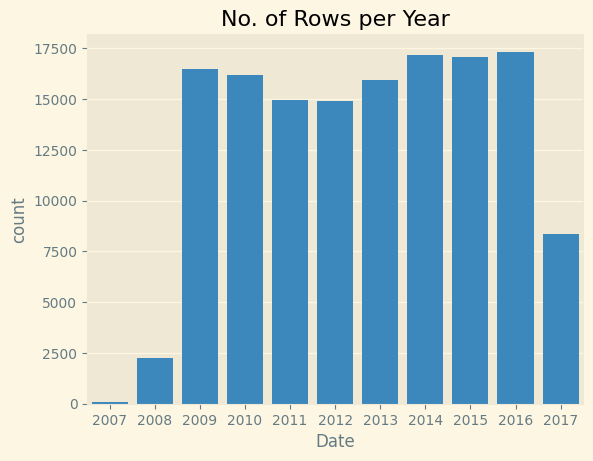

In [37]:
sns.countplot(x=pd.to_datetime(weather_df.Date).dt.year);
plt.title('No. of Rows per Year')

In [38]:
year = pd.to_datetime(weather_df.Date).dt.year

train_df_year = split_df[year < 2015]
val_df_year = split_df[year == 2015]
test_df_year = split_df[year > 2015]

In [39]:
print('train_df.shape :', train_df_year.shape)
print('val_df.shape :', val_df_year.shape)
print('test_df.shape :', test_df_year.shape)

train_df.shape : (97988, 118)
val_df.shape : (17089, 118)
test_df.shape : (25710, 118)


In [40]:
train_df_year.head(2)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir3pm_nan
81333,8.9,30.7,0.0,7.0,12.5,33.0,11.0,15.0,60.0,19.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85721,13.4,23.0,0.0,1.8,2.6,26.0,6.0,4.0,85.0,83.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## 5.Identifying Input and Target Columns

Often, not all the columns in a dataset are useful for training a model. In the current dataset, we can ignore the `Date` column, since we only want to weather conditions to make a prediction about whether it will rain the next day.

Let's create a list of input columns, and also identify the target column.

In [41]:
train_df.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm',
       ...
       'WindDir3pm_NW', 'WindDir3pm_S', 'WindDir3pm_SE', 'WindDir3pm_SSE',
       'WindDir3pm_SSW', 'WindDir3pm_SW', 'WindDir3pm_W', 'WindDir3pm_WNW',
       'WindDir3pm_WSW', 'WindDir3pm_nan'],
      dtype='object', length=118)

In [42]:
input_cols = list(train_df.columns)
input_cols.remove('isRainTomorrow')
target_col = 'isRainTomorrow'

In [43]:
print(input_cols)

['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'isRainToday', 'Location_Adelaide', 'Location_Albany', 'Location_Albury', 'Location_AliceSprings', 'Location_BadgerysCreek', 'Location_Ballarat', 'Location_Bendigo', 'Location_Brisbane', 'Location_Cairns', 'Location_Canberra', 'Location_Cobar', 'Location_CoffsHarbour', 'Location_Dartmoor', 'Location_Darwin', 'Location_GoldCoast', 'Location_Hobart', 'Location_Katherine', 'Location_Launceston', 'Location_Melbourne', 'Location_MelbourneAirport', 'Location_Mildura', 'Location_Moree', 'Location_MountGambier', 'Location_MountGinini', 'Location_Newcastle', 'Location_Nhil', 'Location_NorahHead', 'Location_NorfolkIsland', 'Location_Nuriootpa', 'Location_PearceRAAF', 'Location_Penrith', 'Location_Perth', 'Location_PerthAirport', 'Location_Portland', 'Location_Richmond', 'Location_Sa

In [44]:
target_col

'isRainTomorrow'

## 6.Create inputs and targets
 for the training, validation and test sets for further processing and model training.

In [45]:
if split_by_year:
    X_train = train_df_year[input_cols].copy()
    y_train = train_df_year[target_col].copy()

    X_val = val_df_year[input_cols].copy()
    y_val = val_df_year[target_col].copy()

    X_test = test_df_year[input_cols].copy()
    y_test = test_df_year[target_col].copy()
else:
    X_train = train_df[input_cols].copy()
    y_train = train_df[target_col].copy()

    X_val = val_df[input_cols].copy()
    y_val = val_df[target_col].copy()

    X_test = test_df[input_cols].copy()
    y_test = test_df[target_col].copy()

In [46]:
X_train.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir3pm_nan
81333,8.9,30.7,0.0,7.000000,12.50000,33.0,11.0,15.0,60.0,19.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85721,13.4,23.0,0.0,1.800000,2.60000,26.0,6.0,4.0,85.0,83.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
33798,11.5,19.4,6.4,2.600000,6.40000,52.0,17.0,17.0,87.0,50.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73620,10.8,26.4,0.0,5.472516,7.63054,54.0,28.0,35.0,37.0,23.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
106406,7.2,14.6,0.0,4.600000,5.60000,37.0,19.0,19.0,87.0,53.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
y_train.head()

,isRainTomorrow
81333,0
85721,1
33798,1
73620,0
106406,0


## 7.Scaling Numeric Features

Another good practice is to scale numeric features to a small range of values e.g. $(0,1)$ or $(-1,1)$. Scaling numeric features ensures that no particular feature has a disproportionate impact on the model's loss. Optimization algorithms also work better in practice with smaller numbers.

I used MinMaxScalar so one-hot encoding columns not effected

In [48]:
# ?MinMaxScaler

In [49]:
scaler = scaler_model()
scaler.fit(X_train[numeric_cols])

MinMaxScaler()

In [50]:
X_train[numeric_cols] = scaler.transform(X_train[numeric_cols])
X_val[numeric_cols] = scaler.transform(X_val[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [51]:
X_train[numeric_cols].describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000
mean,0.483689,0.519590,0.006396,0.065020,0.532714,0.265107,0.161970,0.215668,0.686309,0.514693,0.612014,0.596437,0.483192,0.493693,0.493189,0.520333
std,0.149458,0.133673,0.022962,0.038060,0.203741,0.102420,0.102805,0.101424,0.189008,0.206376,0.111335,0.109954,0.255486,0.238028,0.138521,0.133024
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.377358,0.421456,0.000000,0.046117,0.524476,0.193798,0.080460,0.149425,0.570000,0.370000,0.543802,0.526403,0.333333,0.333333,0.392625,0.423828
50%,0.478774,0.507663,0.000000,0.066414,0.533604,0.255814,0.149425,0.218391,0.690000,0.520000,0.614125,0.598316,0.492351,0.499917,0.488069,0.509766
75%,0.591981,0.613027,0.002156,0.067961,0.643357,0.310078,0.218391,0.275862,0.830000,0.650000,0.682645,0.665017,0.666667,0.666667,0.590022,0.609375
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# **Show all columns**

In [52]:
pd.set_option('display.max_columns', 117)

In [53]:
X_train

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,isRainToday,Location_Adelaide,Location_Albany,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,Location_Cobar,Location_CoffsHarbour,Location_Dartmoor,Location_Darwin,Location_GoldCoast,Location_Hobart,Location_Katherine,Location_Launceston,Location_Melbourne,Location_MelbourneAirport,Location_Mildura,Location_Moree,Location_MountGambier,Location_MountGinini,Location_Newcastle,Location_Nhil,Location_NorahHead,Location_NorfolkIsland,Location_Nuriootpa,Location_PearceRAAF,Location_Penrith,Location_Perth,Location_PerthAirport,Location_Portland,Location_Richmond,Location_Sale,Location_SalmonGums,Location_Sydney,Location_SydneyAirport,Location_Townsville,Location_Tuggeranong,Location_Uluru,Location_WaggaWagga,Location_Walpole,Location_Watsonia,Location_Williamtown,Location_Witchcliffe,Location_Wollongong,Location_Woomera,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindGustDir_nan,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir9am_nan,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir3pm_nan
81333,0.410377,0.666667,0.000000,0.084951,0.874126,0.209302,0.126437,0.172414,0.60,0.19,0.631405,0.612211,0.492351,0.499917,0.522777,0.660156,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85721,0.516509,0.519157,0.000000,0.021845,0.181818,0.155039,0.068966,0.045977,0.85,0.83,0.753719,0.744224,0.777778,0.888889,0.470716,0.482422,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
33798,0.471698,0.450192,0.017251,0.031553,0.447552,0.356589,0.195402,0.195402,0.87,0.50,0.661157,0.618812,0.777778,0.333333,0.405640,0.468750,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73620,0.455189,0.584291,0.000000,0.066414,0.533604,0.372093,0.321839,0.402299,0.37,0.23,0.510744,0.478548,0.492351,0.499917,0.533623,0.580078,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

# **Save Results**
you can use pd.read_parquet to load it back

In [54]:
X_train.to_parquet('X_train.parquet')
X_val.to_parquet('X_val.parquet')
X_test.to_parquet('X_test.parquet')

In [55]:
pd.DataFrame(y_train).to_parquet('y_train.parquet')
pd.DataFrame(y_val).to_parquet('y_val.parquet')
pd.DataFrame(y_test).to_parquet('y_test.parquet')

# **Make Classes Balanced**

In [56]:
y_train.value_counts()

,count
isRainTomorrow,
0,76190
1,21798


In [57]:
if over_sampling:
    # X_train_oversampled, y_train_oversampled = RandomOverSampler().fit_resample(X_train, y_train)
    X_train_oversampled, y_train_oversampled = oversample_model().fit_resample(X_train, y_train)

In [58]:
if over_sampling:
    print(y_train_oversampled.value_counts())

# **Training a Logistic Regression Model**

## Description

Logistic regression is a commonly used technique for solving binary classification problems. In a logistic regression model:

- we take linear combination (or weighted sum of the input features)
- we apply the sigmoid function to the result to obtain a number between 0 and 1
- this number represents the probability of the input being classified as "Yes"
- instead of RMSE, the cross entropy loss function is used to evaluate the results


Here's a visual summary of how a logistic regression model is structured ([source](http://datahacker.rs/005-pytorch-logistic-regression-in-pytorch/)):


<img src="https://i.imgur.com/YMaMo5D.png" width="480">

The sigmoid function applied to the linear combination of inputs has the following formula:

<img src="https://i.imgur.com/sAVwvZP.png" width="400">


The output of the sigmoid function is called a logistic, hence the name _logistic regression_. For a mathematical discussion of logistic regression, sigmoid activation and cross entropy, check out [this YouTube playlist](https://www.youtube.com/watch?v=-la3q9d7AKQ&list=PLNeKWBMsAzboR8vvhnlanxCNr2V7ITuxy&index=1). Logistic regression can also be applied to multi-class classification problems, with a few modifications.


## Check inputs

In [59]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97988 entries, 81333 to 122693
Columns: 117 entries, MinTemp to WindDir3pm_nan
dtypes: float64(116), int8(1)
memory usage: 87.6 MB


In [60]:
if over_sampling:
  X_train_oversampled.info()

In [61]:
X_train.isna().sum().sum()

np.int64(0)

## Train the model
inputs should be numerical but targets can be categorical

In [62]:
model = LogisticRegression(solver="liblinear")

In [63]:
%%time
if over_sampling:
  model.fit(X_train_oversampled, y_train_oversampled)
else:
  model.fit(X_train, y_train)

CPU times: user 1.53 s, sys: 61.9 ms, total: 1.59 s
Wall time: 1.59 s


## Columns and Weights side by side

In [64]:
# Get column names
feature_names = X_train.columns

# Get coefficients
weights = model.coef_.tolist()  # [0] because it's a binary classification

# Create a DataFrame
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Weight': weights[0]
})

# Sort by absolute weight (importance)
coef_df = coef_df.sort_values(by='Weight', key=abs, ascending=False)

coef_df

,Feature,Weight
11,Pressure3pm,-8.974320
5,WindGustSpeed,6.764015
9,Humidity3pm,5.990765
10,Pressure9am,5.523401
2,Rainfall,3.174954
...,...,...
38,Location_Moree,-0.017957
82,WindGustDir_nan,0.013996
62,Location_Williamtown,-0.011591
116,WindDir3pm_nan,-0.010698


In [65]:
coef_df.loc[coef_df["Feature"] == "isRainToday", "Weight"].values[0]

np.float64(0.4977822283266228)

## Evaluation the model

### Predict

In [66]:
y_true_test = y_test
y_pred_test = model.predict(X_test)

In [67]:
if over_sampling:
    y_true_train = y_train_oversampled
    y_pred_train = model.predict(X_train_oversampled)
else:
    y_true_train = y_train
    y_pred_train = model.predict(X_train)

We can output a probabilistic prediction using `predict_proba`.
Give us how confident the model is about the prediction

In [68]:
test_probs = model.predict_proba(X_test)

In [69]:
model.classes_, test_probs

(array([0, 1], dtype=int8),
 array([[0.9281328 , 0.0718672 ],
        [0.9497307 , 0.0502693 ],
        [0.78657041, 0.21342959],
        ...,
        [0.93525845, 0.06474155],
        [0.85663533, 0.14336467],
        [0.03679816, 0.96320184]]))

### Metrics report

In [70]:
print("Test\n", classification_report(y_true=y_true_test, y_pred=y_pred_test))

Test
               precision    recall  f1-score   support

           0       0.86      0.95      0.90     19885
           1       0.73      0.48      0.58      5825

    accuracy                           0.84     25710
   macro avg       0.80      0.71      0.74     25710
weighted avg       0.83      0.84      0.83     25710



In [71]:
print("Train\n", classification_report(y_true=y_true_train, y_pred=y_pred_train))

Train
               precision    recall  f1-score   support

           0       0.87      0.95      0.91     76190
           1       0.74      0.52      0.61     21798

    accuracy                           0.85     97988
   macro avg       0.80      0.73      0.76     97988
weighted avg       0.84      0.85      0.84     97988



### Confusion Matrix

The model achieves an accuracy of 84.2% on the training set. We can visualize the breakdown of correctly and incorrectly classified inputs using a confusion matrix.

<img src="https://i.imgur.com/UM28BCN.png" width="480">

In [72]:
cm = confusion_matrix(y_true=y_true_test, y_pred=y_pred_test, normalize="true")

<Axes: >

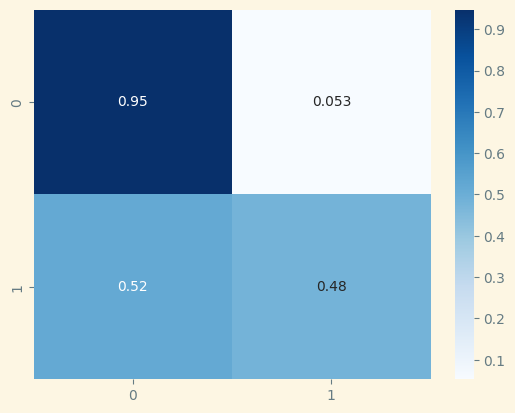

In [73]:
sns.heatmap(data=cm, annot=True, cmap="Blues")

### Compare with dumb model

The accuracy of the model on the test and validation set are above 84%, which suggests that our model generalizes well to data it hasn't seen before.

But how good is 84% accuracy? While this depends on the nature of the problem and on business requirements, a good way to verify whether a model has actually learned something useful is to compare its results to a "random" or "dumb" model.

Let's create two models: one that guesses randomly and another that always return "No". Both of these models completely ignore the inputs given to them.

In [74]:
def random_guess(inputs):
    return np.random.choice([0, 1], len(inputs))

In [75]:
def all_no(inputs):
    return np.full(len(inputs), 0)

In [76]:
accuracy_score(y_true_test, random_guess(X_test))

0.4982497082847141

In [77]:
accuracy_score(y_true_test, all_no(X_test))

0.7734344612991054

Our random model achieves an accuracy of 50% and our "always No" model achieves an accuracy of 77%.

Thankfully, our model is better than a "dumb" or "random" model! This is not always the case, so it's a good practice to benchmark any model you train against such baseline models.

# **Making Predictions on a Single Input**

In [78]:
new_input = {'Date': '2021-06-19',
             'Location': 'Katherine',
             'MinTemp': 23.2,
             'MaxTemp': 33.2,
             'Rainfall': 10.2,
             'Evaporation': 4.2,
             'Sunshine': np.nan,
             'WindGustDir': 'NNW',
             'WindGustSpeed': 52.0,
             'WindDir9am': 'NW',
             'WindDir3pm': 'NNE',
             'WindSpeed9am': 13.0,
             'WindSpeed3pm': 20.0,
             'Humidity9am': 40.0,
             'Humidity3pm': 90.0,
             'Pressure9am': 1004.8,
             'Pressure3pm': 1001.5,
             'Cloud9am': 8.0,
             'Cloud3pm': 5.0,
             'Temp9am': 25.7,
             'Temp3pm': 33.0,
             'isRainToday': 1
             }

In [79]:
new_input_df = pd.DataFrame([new_input])

In [80]:
new_input_df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,isRainToday
0,2021-06-19,Katherine,23.2,33.2,10.2,4.2,NaN,NNW,52.0,NW,NNE,13.0,20.0,40.0,90.0,1004.8,1001.5,8.0,5.0,25.7,33.0,1


In [81]:
%%capture
new_input_df[numeric_cols] = imputer.transform(new_input_df[numeric_cols])
new_input_df[numeric_cols] = scaler.transform(new_input_df[numeric_cols])
new_input_df[encoded_cols] = encoder.transform(new_input_df[categorical_cols])

In [82]:
new_input_df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,isRainToday,Location_Adelaide,Location_Albany,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,Location_Cobar,Location_CoffsHarbour,Location_Dartmoor,Location_Darwin,Location_GoldCoast,Location_Hobart,Location_Katherine,Location_Launceston,Location_Melbourne,Location_MelbourneAirport,Location_Mildura,Location_Moree,Location_MountGambier,Location_MountGinini,Location_Newcastle,Location_Nhil,Location_NorahHead,Location_NorfolkIsland,Location_Nuriootpa,Location_PearceRAAF,Location_Penrith,Location_Perth,Location_PerthAirport,Location_Portland,Location_Richmond,Location_Sale,...,Location_WaggaWagga,Location_Walpole,Location_Watsonia,Location_Williamtown,Location_Witchcliffe,Location_Wollongong,Location_Woomera,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindGustDir_nan,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir9am_nan,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir3pm_nan
0,2021-06-19,Katherine,0.747642,0.714559,0.027493,0.050971,0.533604,NNW,0.356589,NW,NNE,0.149425,0.229885,0.4,0.9,0.401653,0.371287,0.888889,0.555556,0.685466,0.744141,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [83]:
new_input_df.drop(columns=categorical_cols + ["Date"], inplace=True)

In [84]:
prediction = model.predict(new_input_df)[0]
prediction

np.int8(1)

In [85]:
prob = model.predict_proba(new_input_df)[0]

In [86]:
prob

array([0.13801424, 0.86198576])

# **Save and Load Model**

In [87]:
import joblib

Let's first create a dictionary containing all the required objects.

## Save

In [88]:
rain_model = {
    'model': model,
    'imputer': imputer,
    'scaler': scaler,
    'encoder': encoder,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols
}

We can now save this to a file using `joblib.dump`

In [89]:
joblib.dump(rain_model, "rain_model.joblib")

['rain_model.joblib']

## Load

In [90]:
rain_model_loaded = joblib.load("rain_model.joblib")

In [91]:
y_pred_loaded = rain_model_loaded["model"].predict(X_test)

In [92]:
print(classification_report(y_true=y_test, y_pred=y_pred_loaded)) # Same result

              precision    recall  f1-score   support

           0       0.86      0.95      0.90     19885
           1       0.73      0.48      0.58      5825

    accuracy                           0.84     25710
   macro avg       0.80      0.71      0.74     25710
weighted avg       0.83      0.84      0.83     25710



# **Training a XGBoost Model**

In [93]:
xg_model = xgb.XGBClassifier(random_state=45)

In [94]:
%%time
if over_sampling:
  xg_model.fit(X_train_oversampled, y_train_oversampled)
else:
  xg_model.fit(X_train, y_train)

CPU times: user 5.83 s, sys: 29.2 ms, total: 5.86 s
Wall time: 3.08 s


In [95]:
y_pred_xg = xg_model.predict(X_test)

In [96]:
print(classification_report(y_true=y_test, y_pred=y_pred_xg))

              precision    recall  f1-score   support

           0       0.87      0.94      0.91     19885
           1       0.74      0.54      0.62      5825

    accuracy                           0.85     25710
   macro avg       0.81      0.74      0.76     25710
weighted avg       0.84      0.85      0.84     25710



In [97]:
if over_sampling:
  print(classification_report(y_true=y_train_oversampled, y_pred=xg_model.predict(X_train_oversampled)))
else:
  print(classification_report(y_true=y_train, y_pred=xg_model.predict(X_train)))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93     76190
           1       0.84      0.65      0.73     21798

    accuracy                           0.89     97988
   macro avg       0.87      0.81      0.83     97988
weighted avg       0.89      0.89      0.89     97988



# **Resources to learn more**

* https://www.youtube.com/watch?v=-la3q9d7AKQ&list=PLNeKWBMsAzboR8vvhnlanxCNr2V7ITuxy&index=1
* https://www.kaggle.com/prashant111/extensive-analysis-eda-fe-modelling
* https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction#Baseline
* https://jovian.ai/aakashns/03-logistic-regression
